<a href="https://colab.research.google.com/github/JoelAyet/MC1/blob/main/CG_Martini_sim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Colab Martini coarse-grain molecular dynamics simulation
#### Author: Joel Ayet
#### Year: 2025
#### Project: Type I metacaspases

In [ ]:
# @title STEP 1: Environment Setup & Sanity Checks

# Install Conda and required packages
!pip install -q condacolab
import condacolab
condacolab.install()

!mamba install -c conda-forge openmm==8.2 mdtraj nglview vermouth ffmpeg -y
!pip install -q git+https://github.com/maccallumlab/martini_openmm.git

# Import main libraries and perform checks
import nglview as nv
import ipywidgets as ipw
import mdtraj as md
from openmm import Platform
import os
import sys

print("\n--- Sanity Checks ---")
# Check for CUDA platform (GPU)
try:
    Platform.getPlatformByName("CUDA")
    print("✅  CUDA platform found (GPU is active).")
except Exception:
    print("⚠️  No GPU found. Please go to Runtime > Change runtime type and select GPU.")

# Check martinize2 version
print("\nVerifying martinize2 installation:")
!martinize2 --version

print("\n✅ Environment is ready.")

In [ ]:
# @title STEP 2: Define a base name for the project files
# All generated files (cg.pdb, cg.top, traj.dcd, etc.) will use this name.
SYSTEM_NAME = "protein_complex"

from google.colab import files
import os

print("Please upload your PDB file of the protein complex.")
# Clear any previously uploaded files to avoid confusion
if 'uploaded_files' in globals():
    del uploaded_files

uploaded_files = files.upload()

if not uploaded_files:
    raise FileNotFoundError("No file uploaded. Please run the cell again.")

pdb_file = list(uploaded_files.keys())[0]
os.rename(pdb_file, f"{SYSTEM_NAME}_atomistic.pdb")
pdb_file = f"{SYSTEM_NAME}_atomistic.pdb"
print(f"\n✅ Using uploaded file: {pdb_file}")

Please upload your PDB file of the protein complex.


Saving ANMC1_ANMC2.pdb to ANMC1_ANMC2 (1).pdb

✅ Using uploaded file: protein_complex_atomistic.pdb


In [ ]:
# @title STEP 3: Coarse-Grain the System with Martinize2

cg_pdb = f"{SYSTEM_NAME}_cg.pdb"
cg_top = f"{SYSTEM_NAME}_cg.top"
ff_name = "martini3001"

print(f"⏳ Martinizing {pdb_file} with the {ff_name} force field...")

# The -f flag specifies the input file.
# The -o flag specifies the output topology file.
# The -x flag specifies the output coarse-grained structure file.
# The -ff flag selects the force field to use.
!martinize2 -f {pdb_file} -o {cg_top} -x {cg_pdb} -ff {ff_name}

print(f"\n✅ Martinize2 successfully produced '{cg_pdb}' and '{cg_top}'.")

⏳ Martinizing protein_complex_atomistic.pdb with the martini3001 force field...
    INFO - general - Read 2 molecules from PDB file protein_complex_atomistic.pdb
    INFO - step - Guessing the bonds.
    INFO - general - 2 molecules after guessing bonds
    INFO - step - Repairing the graph.
    INFO - general - Applying modification N-ter to residue A-ARG1
    INFO - general - Applying modification C-ter to residue A-LEU287
    INFO - general - Applying modification N-ter to residue B-ARG1
    INFO - general - Applying modification C-ter to residue B-LEU302
    INFO - step - Dealing with modifications.
    INFO - general - Identified the modifications ['N-ter'] on residues ['ARG1', 'ARG1', 'ARG1', 'ARG1']
    INFO - general - Identified the modifications ['C-ter'] on residues ['LEU287', 'LEU287', 'LEU287']
    INFO - general - Identified the modifications ['N-ter'] on residues ['ARG1', 'ARG1', 'ARG1', 'ARG1']
    INFO - general - Identified the modifications ['C-ter'] on residues ['LE

In [ ]:
#@title STEP 4 – CG-MD Simulation

from openmm.app import *
from openmm import *
from openmm.unit import *
import martini_openmm
from martini_openmm import MartiniTopFile
import mdtraj as md
import sys
import time
import pathlib
import shutil
import numpy as np
from datetime import datetime
from google.colab import drive

# --- Simulation Parameters ---
# Modify these values to easily change simulation conditions.
SIM_TIME_NS = 1000         # Simulation time in nanoseconds
TEMPERATURE_K = 295     # Temperature in Kelvin
BOX_PADDING_NM = 1.0    # Padding around the molecule to define the box size
DRIVE_SAVE_DIR = "/content/drive/My Drive/martini_simulations" # Base directory in GDrive

# --- Main Simulation Function ---
def run_cg_simulation(system_name, sim_time_ns, temp_k, padding_nm, drive_base_dir):
    """
    Sets up and runs a Martini CG-MD simulation with OpenMM.

    Args:
        system_name (str): The base name for input/output files (e.g., "complex").
        sim_time_ns (int): The total simulation time in nanoseconds.
        temp_k (int): The simulation temperature in Kelvin.
        padding_nm (float): Padding in nm to add around the molecule for the box.
        drive_base_dir (str): The base path in Google Drive to save results.
    """
    # Define file names based on the system name
    cg_pdb_path = f"{system_name}_cg.pdb"
    cg_top_path = f"{system_name}_cg.top"
    traj_dcd_path = f"{system_name}_traj.dcd"

    # --- 1. Mount Google Drive for saving results ---
    print("⏳ Mounting Google Drive...")
    drive.mount('/content/drive', force_remount=True)

    # --- 2. Clone Martini FF repo and prepare local files ---
    print("⏳ Cloning martini_openmm repository for force field files...")
    if os.path.exists('martini_openmm_repo'):
        shutil.rmtree('martini_openmm_repo')
    !git clone --depth 1 https://github.com/maccallumlab/martini_openmm.git martini_openmm_repo > /dev/null 2>&1

    local_ff_dir = pathlib.Path('martini_ff_local')
    if local_ff_dir.exists():
        shutil.rmtree(local_ff_dir)
    local_ff_dir.mkdir()

    repo_path = pathlib.Path('martini_openmm_repo')
    source_ff_dir = next(repo_path.rglob('martini_v3.0.0.itp')).parent

    if not source_ff_dir:
        raise FileNotFoundError("Could not find the source force field directory in the cloned repo.")

    print(f"✅ Found FF directory: {source_ff_dir}")
    print(f"⏳ Copying .itp files to local directory: {local_ff_dir}")
    for itp_file in source_ff_dir.glob('*.itp'):
        shutil.copy(itp_file, local_ff_dir / itp_file.name)
    shutil.copy(local_ff_dir / 'martini_v3.0.0.itp', local_ff_dir / 'martini.itp')

    # --- 3. Set up the System with a Dynamic Box Size ---
    print("\n⏳ Setting up the OpenMM system...")
    pdb = PDBFile(cg_pdb_path)

    # Dynamically determine box size based on molecule dimensions + padding
    positions_nm = pdb.positions.value_in_unit(nanometer)
    min_coords = np.min(positions_nm, axis=0)
    max_coords = np.max(positions_nm, axis=0)
    box_dimensions = (max_coords - min_coords) + 2 * padding_nm

    box_vectors = (
        Vec3(box_dimensions[0], 0, 0),
        Vec3(0, box_dimensions[1], 0),
        Vec3(0, 0, box_dimensions[2])
    ) * nanometer
    pdb.topology.setPeriodicBoxVectors(box_vectors)
    print(f"📦 Set periodic box size to: {box_dimensions.round(2)} nm")

    topfile = MartiniTopFile(
        cg_top_path,
        periodicBoxVectors=pdb.topology.getPeriodicBoxVectors(),
        includeDir=str(local_ff_dir),
        epsilon_r=15.0
    )
    system = topfile.create_system()

    # --- 4. Configure the Integrator and Simulation ---
    integrator = LangevinIntegrator(temp_k*kelvin, 1/picosecond, 0.02*picoseconds)
    platform = Platform.getPlatformByName('CUDA')
    sim = Simulation(pdb.topology, system, integrator, platform, {"Precision": "mixed"})
    sim.context.setPositions(pdb.positions)

    # --- 5. Minimize and Equilibrate ---
    print("⏳ Minimizing energy...")
    sim.minimizeEnergy(maxIterations=1000)
    print("⏳ Equilibrating (100 ps)...")
    sim.context.setVelocitiesToTemperature(temp_k*kelvin)
    sim.step(int(100*picoseconds / (0.02*picoseconds)))

    # --- 6. Run Production MD ---
    n_steps = int(sim_time_ns*nanoseconds / (0.02*picoseconds))
    report_interval = int(n_steps / 200) # Report progress ~200 times
    dcd_interval = int(50*picoseconds / (0.02*picoseconds)) # Save coordinates every 50 ps

    sim.reporters.append(DCDReporter(traj_dcd_path, dcd_interval))
    sim.reporters.append(StateDataReporter(
        sys.stdout, report_interval, step=True, temperature=True, progress=True,
        remainingTime=True, speed=True, totalSteps=n_steps, separator=','
    ))

    print(f"\n🚀 Starting {sim_time_ns} ns production run ({n_steps:,} steps)...")
    t0 = time.time()
    sim.step(n_steps)
    t1 = time.time()
    print(f"\n✅ CG-MD finished in {(t1 - t0) / 60:.2f} minutes.")

    # --- 7. Save results to a unique folder in Google Drive ---
    timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M")
    drive_save_path = pathlib.Path(drive_base_dir) / f"{system_name}_{timestamp}"
    os.makedirs(drive_save_path, exist_ok=True)

    print(f"\n💾 Saving results to: {drive_save_path}")
    files_to_save = [traj_dcd_path, cg_pdb_path, cg_top_path]
    for f in files_to_save:
        if os.path.exists(f):
            shutil.copy(f, drive_save_path)
            print(f"  - Copied {f}")
        else:
            print(f"  - WARNING: {f} not found, skipping.")

    print("✅ All results saved successfully to Google Drive.")
    return str(drive_save_path)


# Check if the required input files exist before running
if not os.path.exists(f"{SYSTEM_NAME}_cg.pdb") or not os.path.exists(f"{SYSTEM_NAME}_cg.top"):
    raise FileNotFoundError("Could not find the coarse-grained PDB and TOP files. Please run the martinize2 step first.")

latest_results_folder = run_cg_simulation(
    system_name=SYSTEM_NAME,
    sim_time_ns=SIM_TIME_NS,
    temp_k=TEMPERATURE_K,
    padding_nm=BOX_PADDING_NM,
    drive_base_dir=DRIVE_SAVE_DIR
)


⏳ Mounting Google Drive...
Mounted at /content/drive
⏳ Cloning martini_openmm repository for force field files...
✅ Found FF directory: martini_openmm_repo/tutorial/martini
⏳ Copying .itp files to local directory: martini_ff_local

⏳ Setting up the OpenMM system...
📦 Set periodic box size to: [9.33 9.03 7.24] nm
⏳ Minimizing energy...
⏳ Equilibrating (100 ps)...

🚀 Starting 1000 ns production run (50,000,000 steps)...
#"Progress (%)","Step","Temperature (K)","Speed (ns/day)","Time Remaining"
0.5%,250000,301.3890070419691,0,--
1.0%,500000,296.7218940413312,6.04e+03,3:56:02
1.5%,750000,296.148038989548,6.06e+03,3:54:02
2.0%,1000000,293.41613958985033,6.05e+03,3:53:05
2.5%,1250000,277.21863811509206,6.06e+03,3:51:40
3.0%,1500000,313.3283120920424,6.06e+03,3:50:37
3.5%,1750000,293.6823045027943,6.06e+03,3:49:16
4.0%,2000000,286.8020932413546,6.06e+03,3:48:10
4.5%,2250000,288.8358528078255,6.06e+03,3:46:53
5.0%,2500000,292.7264949620399,6.06e+03,3:45:49
5.5%,2750000,295.0752791375862,6.06e+

--- Analyzing Simulation Stability ---
✅ Loading results from: /content/drive/My Drive/martini_simulations/protein_complex_2025-07-14_13-11
⏳ Loading trajectory...
✅ Trajectory loaded with 20000 frames.

--- Interactive Visualization ---
⚡️ Displaying trajectory with NGLView. You can play, rotate, and zoom.


NGLWidget(max_frame=19999)


--- RMSD Analysis ---
⏳ Calculating CG-Backbone RMSD...
✅ RMSD calculated.


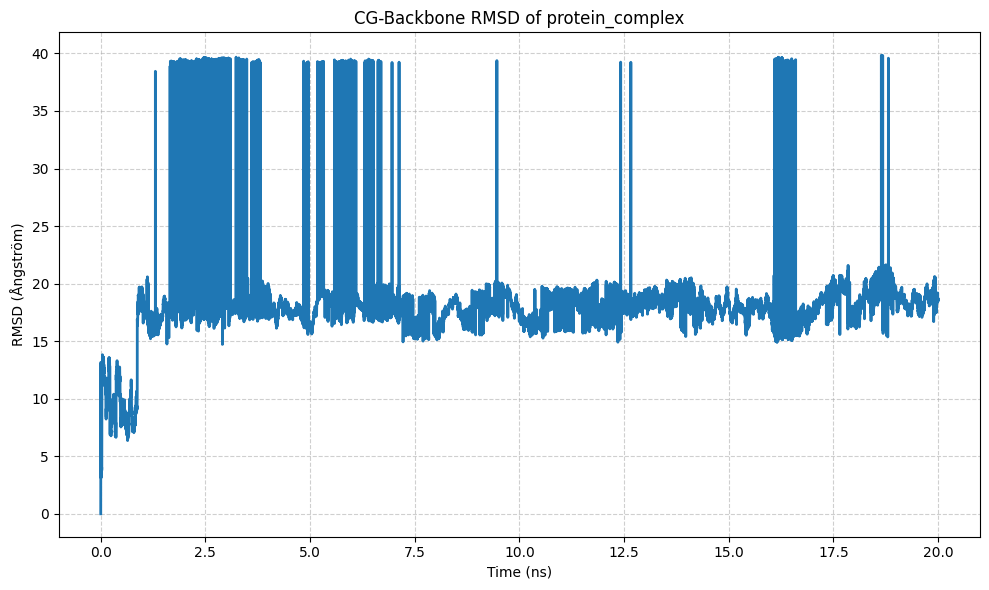

✅ RMSD plot saved to your results folder in Google Drive.

--- How to Interpret the RMSD Plot ---
  - A stable, flat curve that plateaus (e.g., below 3-4 Å) suggests the complex is stable.
  - A continuously rising curve suggests the complex is unstable and changing conformation.


In [ ]:
# @title STEP 5: Analysis & Visualization
import matplotlib.pyplot as plt
import numpy as np
import warnings
import mdtraj as md
import pathlib
import shutil
import nglview as nv
from IPython.display import display
from google.colab import output
output.enable_custom_widget_manager()

# Suppress a common, benign warning from MDTraj about non-standard PDB files
warnings.filterwarnings('ignore', category=UserWarning, module='mdtraj.*')

print("--- Analyzing Simulation Stability ---")

# Ensure the folder from the previous step is available
if 'latest_results_folder' not in globals() or not os.path.isdir(latest_results_folder):
    raise NameError("❌ 'latest_results_folder' not found. Please run the simulation (Step 4) first.")

print(f"✅ Loading results from: {latest_results_folder}")

# --- Define paths to your results ---
dcd_path = pathlib.Path(latest_results_folder) / f"{SYSTEM_NAME}_traj.dcd"
pdb_path = pathlib.Path(latest_results_folder) / f"{SYSTEM_NAME}_cg.pdb"

# --- Load the trajectory and topology ---
try:
    print("⏳ Loading trajectory...")
    traj = md.load(str(dcd_path), top=str(pdb_path))
    print(f"✅ Trajectory loaded with {traj.n_frames} frames.")
except Exception as e:
    raise IOError(f"❌ FATAL ERROR: Could not load trajectory files. Details: {e}")

# --- 1. Quick Interactive Visualization with NGLView ---
print("\n--- Interactive Visualization ---")
print("⚡️ Displaying trajectory with NGLView. You can play, rotate, and zoom.")
view = nv.show_mdtraj(traj)
view.add_representation('licorice', selection='all') # Show a simple representation
display(view)

# --- 2. Calculate and Plot RMSD for the Coarse-Grained Backbone ---
print("\n--- RMSD Analysis ---")
print("⏳ Calculating CG-Backbone RMSD...")
# For Martini, the backbone beads are typically named 'BB'
backbone_indices = traj.topology.select('name BB')

if backbone_indices.size == 0:
    print("❌ WARNING: No 'BB' atoms found for RMSD calculation. Skipping RMSD analysis.")
else:
    # Align trajectory to the first frame before calculating RMSD
    traj.superpose(traj, 0, atom_indices=backbone_indices, ref_atom_indices=backbone_indices)
    rmsd = md.rmsd(traj, traj, 0, atom_indices=backbone_indices) * 10 # convert nm to Angstrom
    time_ns = traj.time / 1000 # convert ps to ns
    print("✅ RMSD calculated.")

    # --- Plot the RMSD ---
    plt.figure(figsize=(10, 6))
    plt.plot(time_ns, rmsd, lw=2)
    plt.title(f'CG-Backbone RMSD of {SYSTEM_NAME}')
    plt.xlabel('Time (ns)')
    plt.ylabel('RMSD (Ångström)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()

    rmsd_plot_path = pathlib.Path(latest_results_folder) / f"{SYSTEM_NAME}_rmsd_plot.png"
    plt.savefig(rmsd_plot_path, dpi=150)
    plt.show()

    print(f"✅ RMSD plot saved to your results folder in Google Drive.")
    print("\n--- How to Interpret the RMSD Plot ---")
    print("  - A stable, flat curve that plateaus (e.g., below 3-4 Å) suggests the complex is stable.")
    print("  - A continuously rising curve suggests the complex is unstable and changing conformation.")


In [ ]:
# @title STEP 6: Create and Save Trajectory Movie

from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import Axes3D

def create_movie_from_traj(traj, save_folder, system_name):
    """
    Generates a 3D movie of the trajectory using Matplotlib and ffmpeg.
    """
    print("\n--- Creating Simulation Movie ---")

    # --- Align the trajectory to remove tumbling/drifting ---
    print("⏳ Aligning trajectory for movie...")
    bb_indices = traj.topology.select('name BB')
    if bb_indices.size > 0:
        traj.superpose(traj, frame=0, atom_indices=bb_indices)
        print("✅ Trajectory aligned.")
    else:
        print("⚠️ Warning: No 'BB' atoms found for alignment. Movie may drift.")

    # --- Create a temporary directory for image frames ---
    frames_dir = pathlib.Path("movie_frames_temp")
    if frames_dir.exists():
        shutil.rmtree(frames_dir)
    frames_dir.mkdir()

    # --- Determine stable plot boundaries and chain colors ---
    xyz = traj.xyz * 10 # convert nm to Angstroms
    x_lim = (np.min(xyz[:,:,0]) - 5, np.max(xyz[:,:,0]) + 5)
    y_lim = (np.min(xyz[:,:,1]) - 5, np.max(xyz[:,:,1]) + 5)
    z_lim = (np.min(xyz[:,:,2]) - 5, np.max(xyz[:,:,2]) + 5)

    chains = {a.residue.chain.index for a in traj.topology.atoms}
    colors = plt.cm.viridis(np.linspace(0, 1, len(chains)))
    chain_colors = {chain_id: color for chain_id, color in zip(sorted(list(chains)), colors)}

    # --- Generate a PNG for a subset of frames ---
    stride = max(1, len(traj) // 150) # Aim for ~150 frames to keep movie short
    frames_to_render = traj[::stride]
    print(f"⏳ Generating {len(frames_to_render)} frames...")

    for i in tqdm(range(len(frames_to_render))):
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111, projection='3d')

        frame_data = frames_to_render[i]

        for chain_id, color in chain_colors.items():
            chain_indices = frame_data.topology.select(f'chainid {chain_id}')
            if chain_indices.size > 0:
                xyz_chain = frame_data.atom_slice(chain_indices).xyz[0] * 10
                ax.plot(xyz_chain[:, 0], xyz_chain[:, 1], xyz_chain[:, 2], color=color, lw=3, label=f'Chain {frame_data.topology.chain(chain_id).chain_id}')

        time_val_ns = frame_data.time[0] / 1000
        ax.set_title(f"{system_name} - Time: {time_val_ns:.2f} ns")
        ax.set_xlabel("X (Å)"); ax.set_ylabel("Y (Å)"); ax.set_zlabel("Z (Å)")
        ax.legend()
        ax.view_init(elev=30, azim=(i*2 % 360)) # Slowly rotate camera
        ax.set_xlim(x_lim); ax.set_ylim(y_lim); ax.set_zlim(z_lim)
        plt.savefig(frames_dir / f"frame_{i:04d}.png", dpi=90)
        plt.close(fig)

    # --- Stitch frames into an MP4 movie ---
    print("⏳ Creating MP4 movie with ffmpeg...")
    movie_path = f"{system_name}_movie.mp4"
    !ffmpeg -y -r 15 -i {frames_dir}/frame_%04d.png -vcodec libx264 -crf 23 -pix_fmt yuv420p {movie_path}

    # --- Save movie to Google Drive and clean up ---
    if os.path.exists(movie_path):
        drive_movie_path = pathlib.Path(save_folder) / movie_path
        shutil.copy(movie_path, drive_movie_path)
        print(f"✅ Movie created and saved to: {drive_movie_path}")
    else:
        print("❌ Movie creation failed.")

    print("🧹 Cleaning up temporary files...")
    shutil.rmtree(frames_dir)
    print("✅ Done.")

# --- Check if trajectory is loaded and run the function ---
if 'traj' not in globals():
    print("❌ Trajectory not loaded. Please run the analysis cell (Step 5) first.")
else:
    create_movie_from_traj(traj, latest_results_folder, SYSTEM_NAME)


--- Creating Simulation Movie ---
⏳ Aligning trajectory for movie...
✅ Trajectory aligned.
⏳ Generating 151 frames...


  0%|          | 0/151 [00:00<?, ?it/s]

⏳ Creating MP4 movie with ffmpeg...
ffmpeg version 7.1.1 Copyright (c) 2000-2025 the FFmpeg developers
  built with gcc 13.3.0 (conda-forge gcc 13.3.0-2)
  configuration: --prefix=/usr/local --cc=/home/conda/feedstock_root/build_artifacts/ffmpeg_1748704110088/_build_env/bin/x86_64-conda-linux-gnu-cc --cxx=/home/conda/feedstock_root/build_artifacts/ffmpeg_1748704110088/_build_env/bin/x86_64-conda-linux-gnu-c++ --nm=/home/conda/feedstock_root/build_artifacts/ffmpeg_1748704110088/_build_env/bin/x86_64-conda-linux-gnu-nm --ar=/home/conda/feedstock_root/build_artifacts/ffmpeg_1748704110088/_build_env/bin/x86_64-conda-linux-gnu-ar --disable-doc --enable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libharfbuzz --enable-libfontconfig --enable-libopenh264 --enable-libdav1d --disable-gnutls --enable-libvpx --enable-libass --enable-pthreads --enable-alsa --enable-libpulse --enable-vaapi --enable-libopenvino --enable-gpl --enable-libx264 --enable-libx265 --